# EM: Expectation-Maximization Algorithm
EM algorithm is a distribution-based clustering aglorithm. EM algorithm's main advantage is it's relevance in finding for maximum likelihood estimators in latent variable models. It is also worthy to note that one of the motivations of the algorithm is that unlike k-means which has hard cut-off boundaries in clustering, EM algorithm uses distributions.

There are only two steps in EM algorithm as follows:
1. E-Step. Estimate the missing variables in the dataset.
2. M-Step. Maximize the parameters of the model in the presence of the data.

One of the most discussed applications of the EM algorithm is for clustering with a mixture model. We will discuss Gausian mixture model in this notebook.

## Gaussian Mixture Model
A mixture model consists of an unspecified combination of multiple probability distribution functions. Here, the learning algorithm estimates the parameters of the probability distributions to best fit the density of a given training dataset.

So for the Gaussian Mixture Model (GMM), it uses a combination of Gaussian (Normal) probability distributions that requires the estimation of the mean and standard deviation parameters for each. In estimating the parameters, the most common method is the *maximum likelihood estimate*.

Consider the case where a dataset is comprised of many points that happen to be generated by **two different processes**. The points for each process have a Gaussian probability distribution, but the data is combined and the distributions are similar enough that it is **not obvious** to which distribution a given point may belong.

The processes used to generate the data point represents a **latent variable**, e.g. process 0 and process 1. It influences the data but is not observable. As such, the EM algorithm is an appropriate approach to use to estimate the parameters of the distributions.

In the EM algorithm, the estimation-step would estimate a value for the process latent variable for each data point, and the maximization step would optimize the parameters of the probability distributions in an attempt to best capture the density of the data. The process is repeated until a good set of latent values and a maximum likelihood is achieved that fits the data.

1. E-Step. Estimate the expected value for each latent variable.
2. M-Step. Optimize the parameters of the distribution using maximum likelihood.
3. Repeat until a good set best fitst the data.

HEre is a diagram showing the covariance matrix and gaussian formula in one-dimension.
<img src = 'figures/cov_gmm.PNG' width= 300>

References: 
The contents of this notebook are heavily taken from Reference 1.
1. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
2. https://towardsdatascience.com/17-clustering-algorithms-used-in-data-science-mining-49dbfa5bf69a#a536
3. https://machinelearningmastery.com/expectation-maximization-em-algorithm/

### Mathematics of GMM

GMM is a soft clustering algorithm where each cluster corresponds to a generative model that aims to discover the parameters of a probability distribution (e.g., mean, covariance, density function…) for a given cluster(its own probability distribution governs each cluster). 

$P(y_1,…,y_n|x_1,…,x_n, θ) = P(x_1,…,x_n, y_1,…,y_n|θ)(joint) / P(x_1,…,x_n|θ)$

The process of learning is to fit a gaussian model to the data points using maximum likelihood estimation. The Gaussian Mixture model assumes that the clusters are distributed in a normal distribution in n-dimensional space. Here, the purpose is to find a parameter θ that maximized the probability of the observed data.

$θ_{ML} = argmax(θP(x_1,…,x_n|θ))$

The goal is to compute the conditional distribution of the latent attributes given the observed dataset.
$P(x_{n+1}, y_{n+1}|x_1,…,x_n, θ)$

Finally, the algorithm finds a class that maximizes the probability of the future data given the learned parameters θ:
$argmax(cP(x_{n+1}|θc))$


## Implementation
We start off by demonstrating the advantage of GMM over k-means.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [3]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

Weakness of k-means:
1. Non-probabilistic nature of k-means and 
2. Use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.



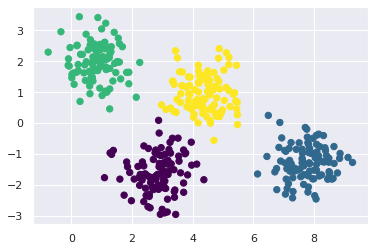

In [4]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From the example above, we may not be very confident about the result as there appears to be a  slight overlap between the two middle clusters. One of the motivations of GM model is that the fact that the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments.

One way to think about the k-means model is that it places a circle (in 2D) at the center of each cluster whose radius is set by the most distant point in the cluster and becomes the cut-off for cluster assignment within the training set. Any point outside this circle is not considered a member of the cluster. Let us visualize it.

In [21]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    print(centers.shape, centers)
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

(4, 2) [[ 2.84849883 -1.61366997]
 [ 7.75608144 -1.2689694 ]
 [ 0.83945671  1.95662677]
 [ 4.36874542  0.95041055]]


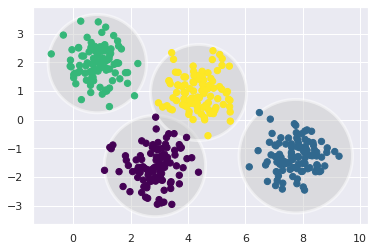

In [22]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

But what if we transform the data? Can k-means still cluster it well?

(4, 2) [[-0.67352972  1.35393896]
 [-5.48072174  5.28698509]
 [-3.1929741   3.73350187]
 [-1.99320416  1.59999263]]


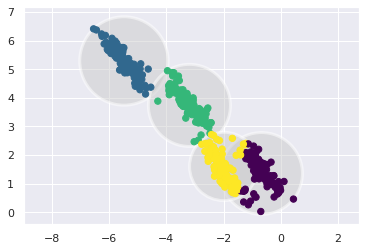

In [44]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

We see that circular k-means cannot cluster the data well at the lower right area and that the circular cut-offs overlap.

These two disadvantages of k-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the k-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters. It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.


A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

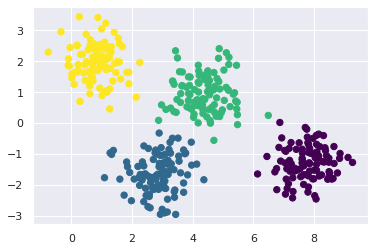

In [46]:
from sklearn import mixture
model = mixture.GaussianMixture(n_components=4, covariance_type='full')

gmm = model.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [47]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.531 0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

In [ ]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

Choose starting guesses for the location and shape

Repeat until converged:

E-step: for each point, find weights encoding the probability of membership in each cluster
M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [53]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

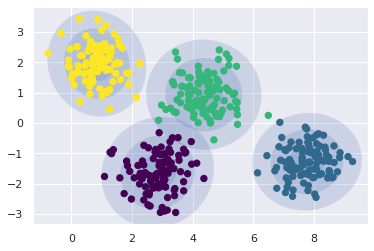

In [54]:
gmm = model.fit(X)
plot_gmm(gmm, X)

We also demonstrate that GMM is efficient in clustering transformed data sets unlike k-means.

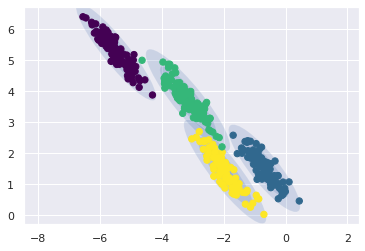

In [55]:
plot_gmm(gmm, X_stretched)

## Extension: GMM for Density Estimation
In this section, we demonstrate another use of GMM which is on data generation. Here GMM serves as a generative probabilistic model which estimates the distribution of the data and gives us the recipe to generate new random data distributed similarly to the input data. Let us consider a data generated from Scikit-Learn's function *make_moons*. 

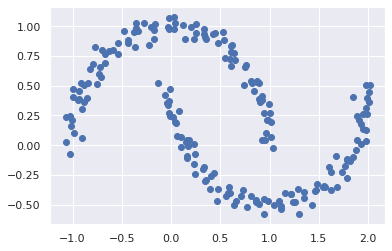

In [59]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

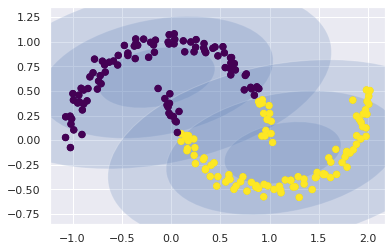

In [65]:
model2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm2 = model2.fit(Xmoon)
labels2 = gmm2.predict(Xmoon)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], c=labels2, s=40, cmap='viridis');
plot_gmm(gmm2, Xmoon)

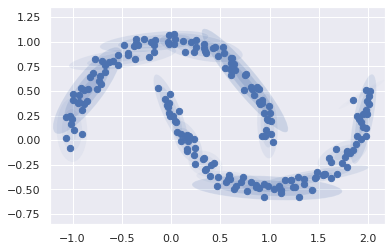

In [66]:
model3 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
gmm16 = model3.fit(Xmoon)
labels16 = gmm16.predict(Xmoon)
# plt.scatter(Xmoon[:, 0], Xmoon[:, 1], c=labels16, s=40, cmap='viridis');
plot_gmm(gmm16, Xmoon, label=False)

Model GMM with 16 components captured the distribution of the data and can now serve as the generative probabilistic model which will allow us to generate another set of data with the same distribution as the input data.

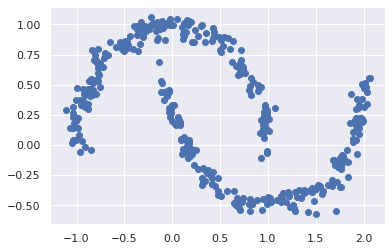

In [80]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:,0], Xnew[0][:, 1]);

The optimal number of clusters for GMM as a **density estimator** is the value that minimizes the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods to compute both of these parameters.

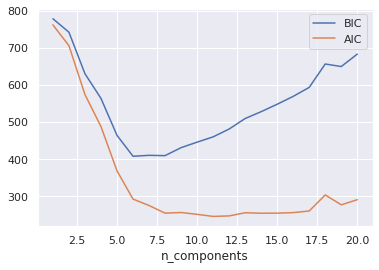

In [81]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

GMM is recommended to be used for density estimator more than for clustering, which is recommended only when warranted within simple datasets.